In [2]:
# %% [markdown]
# #Install Dependencies

# %%
# !pip install scipy
# !pip install torch
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas

import torch
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import scipy.io
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx


from scipy.io import savemat


from scipy.io import loadmat
import seaborn as sns
import pandas as pd


# %% [markdown]
# #Data Preprocessing
# 

# %%
PATH = '../dgl_kaggle/dgl-icl/'
MAT_PATH = '../dgl_kaggle/mat/'

csv_file = PATH + 'lr_train.csv'
df = pd.read_csv(csv_file)

data_dict = {'LR': df.values}

mat_file = MAT_PATH + 'LR_data_160.mat'
savemat(mat_file, data_dict)


# %%
csv_file = PATH + 'hr_train.csv'
df = pd.read_csv(csv_file)

data_dict = {'HR': df.values}

mat_file = MAT_PATH + 'HR_data_268.mat'
savemat(mat_file, data_dict)

# %%
# Path to your .mat files
lr_data_path = MAT_PATH + 'LR_data_160.mat'
hr_data_path = MAT_PATH + 'HR_data_268.mat'

# Load the data
lr_data = loadmat(lr_data_path)
hr_data = loadmat(hr_data_path)

# Print the keys to see what variables are inside
print("LR Data Keys:", lr_data.keys())
print("HR Data Keys:", hr_data.keys())

# Print basic information about 'LR' and 'HR' variables
print("LR Data Type:", type(lr_data['LR']))
print("LR Data Shape:", lr_data['LR'].shape)

print("HR Data Type:", type(hr_data['HR']))
print("HR Data Shape:", hr_data['HR'].shape)

print("Sample from LR Data:", lr_data['LR'][:5])  # Adjust the index range as needed
print("Sample from HR Data:", hr_data['HR'][:5])  # Adjust the index range as needed

# %%
lr_array = lr_data['LR']
hr_array = hr_data['HR']

# Replace all negative values with 0
lr_array[lr_array < 0] = 0
hr_array[hr_array < 0] = 0

# Replace any 'NaN' values with 0
np.nan_to_num(lr_array, copy=False)
np.nan_to_num(hr_array, copy=False)

print(lr_array.shape)
print(hr_array.shape)

# %% [markdown]
# ## 1. Basic Statistics
# 

def calculate_statistics(data):
    statistics = {
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Standard Deviation': np.std(data),
        'Min': np.min(data),
        'Max': np.max(data)
    }
    return statistics

# Calculate statistics for LR and HR data
lr_stats = calculate_statistics(lr_array)
hr_stats = calculate_statistics(hr_array)

# Create a DataFrame to hold the statistics for comparison
df_stats = pd.DataFrame({'LR Data': lr_stats, 'HR Data': hr_stats})

# Round the numbers to four decimal places for better readability
df_stats = df_stats.round(4)

df_stats

# %% [markdown]
# ## 2. Distribution Visualization
# 

# %%
lr_array = lr_data['LR']
hr_array = hr_data['HR']

# Setting the Seaborn theme for nice aesthetics
sns.set_theme(style="whitegrid")

# Plotting histograms on the same figure for comparison
plt.figure(figsize=(10, 6))

# Making histograms semi-transparent with alpha and using a higher bin count for finer detail
sns.histplot(lr_array.flatten(), bins=100, color='blue', alpha=0.5, label='LR Data')
sns.histplot(hr_array.flatten(), bins=100, color='red', alpha=0.5, label='HR Data')

# Adding titles and labels
plt.title('Combined Distribution of LR and HR Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend to differentiate between LR and HR data
plt.legend()

# plt.show()

# %%
# Setting the Seaborn theme for aesthetics
sns.set_theme(style="whitegrid")

# Plotting histograms on the same figure for comparison, excluding zeros
plt.figure(figsize=(10, 6))

# Making histograms semi-transparent with alpha and using a higher bin count for finer detail
# We filter out the zeros using lr_array[lr_array > 0].flatten() and hr_array[hr_array > 0].flatten()
sns.histplot(lr_array[lr_array > 0].flatten(), bins=100, color='blue', alpha=0.5, label='LR Data')
sns.histplot(hr_array[hr_array > 0].flatten(), bins=100, color='red', alpha=0.5, label='HR Data')

# Adding titles and labels
plt.title('Combined Distribution of LR and HR Data (Excluding Zeros)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend to differentiate between LR and HR data
plt.legend()

# Display the plot
# plt.show()

# %% [markdown]
# ## 3. Feature Matrix Heatmap Visualization

# %%
plt.figure(figsize=(20, 8))

# Heatmap of a subset of LR data
plt.subplot(1, 2, 1)
plt.imshow(lr_array, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('LR Data Heatmap')

# Heatmap of a subset of HR data
plt.subplot(1, 2, 2)
plt.imshow(hr_array, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('HR Data Heatmap')

# plt.show()

# %% [markdown]
# ## 4. Brain graph adjacency matrix Heatmap Visualization

# %%
i = 0

import numpy as np

class MatrixVectorizer:
    """
    A class for transforming between matrices and vector representations.

    This class provides methods to convert a symmetric matrix into a vector (vectorize)
    and to reconstruct the matrix from its vector form (anti_vectorize), focusing on
    vertical (column-based) traversal and handling of elements.
    """

    def __init__(self):
        """
        Initializes the MatrixVectorizer instance.

        The constructor currently does not perform any actions but is included for
        potential future extensions where initialization parameters might be required.
        """
        pass

    @staticmethod
    def vectorize(matrix, include_diagonal=False):
        """
        Converts a matrix into a vector by vertically extracting elements.

        This method traverses the matrix column by column, collecting elements from the
        upper triangle, and optionally includes the diagonal elements immediately below
        the main diagonal based on the include_diagonal flag.

        Parameters:
        - matrix (numpy.ndarray): The matrix to be vectorized.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the vectorization.
          Defaults to False.

        Returns:
        - numpy.ndarray: The vectorized form of the matrix.
        """
        # Determine the size of the matrix based on its first dimension
        matrix_size = matrix.shape[0]

        # Initialize an empty list to accumulate vector elements
        vector_elements = []

        # Iterate over columns and then rows to collect the relevant elements
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:
                    if row < col:
                        # Collect upper triangle elements
                        vector_elements.append(matrix[row, col])
                    elif include_diagonal and row == col + 1:
                        # Optionally include the diagonal elements immediately below the diagonal
                        vector_elements.append(matrix[row, col])

        return np.array(vector_elements)

    @staticmethod
    def anti_vectorize(vector, matrix_size, include_diagonal=False):
        """
        Reconstructs a matrix from its vector form, filling it vertically.

        The method fills the matrix by reflecting vector elements into the upper triangle
        and optionally including the diagonal elements based on the include_diagonal flag.

        Parameters:
        - vector (numpy.ndarray): The vector to be transformed into a matrix.
        - matrix_size (int): The size of the square matrix to be reconstructed.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the reconstruction.
          Defaults to False.

        Returns:
        - numpy.ndarray: The reconstructed square matrix.
        """
        # Initialize a square matrix of zeros with the specified size
        matrix = np.zeros((matrix_size, matrix_size))

        # Index to keep track of the current position in the vector
        vector_idx = 0

        # Fill the matrix by iterating over columns and then rows
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:
                    if row < col:
                        # Reflect vector elements into the upper triangle and its mirror in the lower triangle
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1
                    elif include_diagonal and row == col + 1:
                        # Optionally fill the diagonal elements after completing each column
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1

        return matrix



# Now, we use the function for LR and HR data with the right flags
lr_vector = lr_data['LR'][i, :]
hr_vector = hr_data['HR'][i, :]

# Now, we use the function for LR and HR data with the right flags
lr_matrix = MatrixVectorizer.anti_vectorize(lr_vector, 160, include_diagonal=False)
hr_matrix = MatrixVectorizer.anti_vectorize(hr_vector, 268, include_diagonal=False)

# Plot the heatmaps
plt.figure(figsize=(18, 8))

# LR Data Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(lr_matrix, square=True, cmap='viridis')
plt.title('LR Data Heatmap (160x160)')

# HR Data Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(hr_matrix, square=True, cmap='viridis')
plt.title('HR Data Heatmap (268x268)')

# plt.show()

# %% [markdown]
# ##A Toy Example to demonestrate the innerwork of vectorization and  anti-vecotrize function

# %%
# Toy vector for demonstration
toy_vector = np.array([1, 2, 3, 4, 5, 6])  # This is a vectorized upper triangular part of a 4x4 matrix

# The matrix_size is 4 for our toy example
matrix_size = 4

# We call the anti_vectorize function with include_diagonal=False since we are not including the diagonal
toy_matrix = MatrixVectorizer.anti_vectorize(toy_vector, matrix_size, include_diagonal=False)

toy_matrix

# %%
vectorized_matrix = MatrixVectorizer.vectorize(toy_matrix, include_diagonal=False)

vectorized_matrix

# %%
lr_input = lr_matrix.reshape((1,160,160))
hr_input = hr_matrix.reshape((1,268,268))
for i in range(1, lr_array.shape[0]):
    to_append_lr = MatrixVectorizer.anti_vectorize(lr_array[i], 160, include_diagonal=False)
    lr_input = np.concatenate((lr_input, to_append_lr.reshape((1,160,160))), axis=0)
    to_append_hr = MatrixVectorizer.anti_vectorize(hr_array[i], 268, include_diagonal=False)
    hr_input = np.concatenate((hr_input, to_append_hr.reshape((1,268,268))), axis=0)

print(lr_input.shape)
print(hr_input.shape)

# %% [markdown]
# # GSR-Net

# %% [markdown]
# ##0. Data Preprocessing

# %%
'''
path= 'drive/My Drive/BRAIN_DATASET'
roi_str='ROI_FC.mat'
'''

def pad_HR_adj(label, split):
    label=np.pad(label,((split,split),(split,split)),mode="constant")
    np.fill_diagonal(label,1)
    return torch.from_numpy(label).type(torch.FloatTensor)

def unpad(data, split):
    idx_0 = data.shape[0]-split
    idx_1 = data.shape[1]-split
    # print(idx_0,idx_1)
    train = data[split:idx_0, split:idx_1]
    return train

def normalize_adj_torch(mx):
    # mx = mx.to_dense()
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    return mx




'''
# TODO:
def extract_data(subject, session_str, parcellation_str, subjects_roi):
    folder_path = os.path.join(path, str(subject), session_str, parcellation_str)
    roi_data = scipy.io.loadmat(os.path.join(folder_path, roi_str))
    roi=roi_data['r']

    # Replacing NaN values
    col_mean = np.nanmean(roi, axis=0)
    inds = np.where(np.isnan(roi))
    roi[inds] = 1

    # Taking the absolute values of the matrix
    roi = np.absolute(roi,dtype=np.float32)
    # roi = get_tensor(np.array(roi, dtype=np.float32))

    if parcellation_str == 'shen_268':
        roi = np.reshape(roi,(1,268,268))
    else:
        roi = np.reshape(roi,(1,160,160))

    if subject==25629:
        subjects_roi = roi
    else:
        subjects_roi = np.concatenate((subjects_roi,roi),axis=0)

    return subjects_roi

def load_data(start_value, end_value):

    subjects_label = np.zeros((1,268,268))
    subjects_adj = np.zeros((1,160,160))

    # 25840
    for subject in range(start_value, end_value):
        subject_path = os.path.join(path,str(subject))

        if 'session_1' in os.listdir(subject_path):

            subjects_label = extract_data(subject,'session_1', 'shen_268', subjects_label)
            subjects_adj = extract_data(subject,'session_1', 'Dosenbach_160', subjects_adj)

    # for subject in range(25840,)
    return subjects_adj, subjects_label

def data():
    subjects_adj,subjects_labels = load_data(25629,25830)
    test_adj_1, test_labels_1 = load_data(25831, 25863)
    test_adj_2 , test_labels_2 = load_data(30701, 30757)
    test_adj = np.concatenate((test_adj_1,test_adj_2),axis=0)
    test_labels = np.concatenate((test_labels_1,test_labels_2),axis=0)
    return subjects_adj, subjects_labels, test_adj, test_labels
'''

# %% [markdown]
# ##1. Initialization

# %%
def weight_variable_glorot(output_dim):

    input_dim = output_dim
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = np.random.uniform(-init_range, init_range,(input_dim, output_dim))

    return initial

# %% [markdown]
# ##2. Layers

# %%
class GSRLayer(nn.Module):

  def __init__(self, hr_dim):
    super(GSRLayer, self).__init__()

    self.weights = torch.from_numpy(weight_variable_glorot(hr_dim)).type(torch.FloatTensor)
    self.weights = torch.nn.Parameter(data=self.weights, requires_grad = True)

  def forward(self,A,X):
    lr = A
    lr_dim = lr.shape[0]
    f = X
    # eig_val_lr, U_lr = torch.symeig(lr, eigenvectors=True,upper=True)
    eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')
    # U_lr = torch.abs(U_lr)
    eye_mat = torch.eye(lr_dim).type(torch.FloatTensor)
    s_d = torch.cat((eye_mat,eye_mat),0)

    a = torch.matmul(self.weights, s_d)
    b = torch.matmul(a ,torch.t(U_lr))
    f_d = torch.matmul(b ,f)
    f_d = torch.abs(f_d)
    self.f_d = f_d.fill_diagonal_(1)
    adj = normalize_adj_torch(self.f_d)
    X = torch.mm(adj, adj.t())
    X = (X + X.t())/2
    idx = torch.eye(320, dtype=bool)
    X[idx]=1
    return adj, torch.abs(X)



class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    #160x320 320x320 =  160x320
    def __init__(self, in_features, out_features, dropout=0., act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        # input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        # output = self.act(output)
        return output

# %% [markdown]
# ##3. Operations

# %%
class GraphUnpool(nn.Module):

    def __init__(self):
        super(GraphUnpool, self).__init__()

    def forward(self, A, X, idx):
        new_X = torch.zeros([A.shape[0], X.shape[1]])
        new_X[idx] = X
        return A, new_X


class GraphPool(nn.Module):

    def __init__(self, k, in_dim):
        super(GraphPool, self).__init__()
        self.k = k
        self.proj = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, A, X):
        scores = self.proj(X)
        # scores = torch.abs(scores)
        scores = torch.squeeze(scores)
        scores = self.sigmoid(scores/100)
        num_nodes = A.shape[0]
        values, idx = torch.topk(scores, int(self.k*num_nodes))
        new_X = X[idx, :]
        values = torch.unsqueeze(values, -1)
        new_X = torch.mul(new_X, values)
        A = A[idx, :]
        A = A[:, idx]
        return A, new_X, idx


class GCN(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(p=0)

    def forward(self, A, X):

        X = self.drop(X)
        # X = torch.matmul(A, X)
        X = self.proj(X)
        return X

class GraphUnet(nn.Module):

    def __init__(self, ks, in_dim, out_dim, dim=320):
        super(GraphUnet, self).__init__()
        self.ks = ks

        self.start_gcn = GCN(in_dim, dim)
        self.bottom_gcn = GCN(dim, dim)
        self.end_gcn = GCN(2*dim, out_dim)
        self.down_gcns = []
        self.up_gcns = []
        self.pools = []
        self.unpools = []
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim))
            self.up_gcns.append(GCN(dim, dim))
            self.pools.append(GraphPool(ks[i], dim))
            self.unpools.append(GraphUnpool())

    def forward(self, A, X):
        adj_ms = []
        indices_list = []
        down_outs = []
        X = self.start_gcn(A, X)
        start_gcn_outs = X
        org_X = X
        for i in range(self.l_n):

            X = self.down_gcns[i](A, X)
            adj_ms.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)
        X = self.bottom_gcn(A, X)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1

            A, idx = adj_ms[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, idx)
            X = self.up_gcns[i](A, X)
            X = X.add(down_outs[up_idx])
        X = torch.cat([X, org_X], 1)
        X = self.end_gcn(A, X)

        return X, start_gcn_outs

# %% [markdown]
# ##4. Model

# %%
class GSRNet(nn.Module):

  def __init__(self, ks, lr_dim, hr_dim, hidden_dim):
    super(GSRNet, self).__init__()

    self.lr_dim = lr_dim
    self.hr_dim = hr_dim
    self.hidden_dim = hidden_dim
    self.layer = GSRLayer(self.hr_dim)
    self.net = GraphUnet(ks, self.lr_dim, self.hr_dim)
    self.gc1 = GraphConvolution(self.hr_dim, self.hidden_dim, 0, act=F.relu)
    self.gc2 = GraphConvolution(self.hidden_dim, self.hr_dim, 0, act=F.relu)

  def forward(self,lr):

    I = torch.eye(self.lr_dim).type(torch.FloatTensor)
    A = normalize_adj_torch(lr).type(torch.FloatTensor)

    self.net_outs, self.start_gcn_outs = self.net(A, I)
    self.outputs, self.Z = self.layer(A, self.net_outs)

    self.hidden1 = self.gc1(self.Z, self.outputs)
    self.hidden2 = self.gc2(self.hidden1, self.outputs)

    z = self.hidden2
    z = (z + z.t())/2
    idx = torch.eye(self.hr_dim, dtype=bool)
    z[idx]=1

    return torch.abs(z), self.net_outs, self.start_gcn_outs, self.outputs

# %% [markdown]
# ##Train

# %%
criterion = nn.L1Loss()

def train(model, optimizer, subjects_adj, subjects_labels, epochs=200, padding=26, lmbda=16):

  i = 0
  all_epochs_loss = []
  no_epochs = epochs

  for epoch in range(no_epochs):

      epoch_loss = []
      epoch_error = []

      for lr, hr in zip(subjects_adj, subjects_labels):

          model.train()
          optimizer.zero_grad()

          lr = torch.from_numpy(lr).type(torch.FloatTensor)
          hr = torch.from_numpy(hr).type(torch.FloatTensor)


          model_outputs, net_outs, start_gcn_outs, layer_outs = model(lr)

          model_outputs = unpad(model_outputs, padding)

          padded_hr = pad_HR_adj(hr, padding)

          # eig_val_hr, U_hr = torch.symeig(padded_hr, eigenvectors=True,upper=True)
          eig_val_hr, U_hr = torch.linalg.eigh(padded_hr, UPLO='U')

          '''
          print('net_outs', net_outs.shape)
          print('start_gcn_outs', start_gcn_outs.shape)
          print('model.layer.weights', model.layer.weights.shape)
          print('U_hr', U_hr.shape)

          print('model_outputs', model_outputs.shape)
          print('hr', hr.shape)
          '''

          loss = lmbda * criterion(net_outs, start_gcn_outs) + criterion(model.layer.weights, U_hr) + criterion(model_outputs, hr)

          error = criterion(model_outputs, hr)

          loss.backward()
          optimizer.step()

          epoch_loss.append(loss.item())
          epoch_error.append(error.item())

      i+=1
      print("Epoch: ",i, "Loss: ", np.mean(epoch_loss), "Error: ", np.mean(epoch_error)*100,"%")
      all_epochs_loss.append(np.mean(epoch_loss))

#   plt.plot(all_epochs_loss)
#   plt.title('GSR-UNet with self reconstruction: Loss')
#   plt.show(block=False)

def test(model, test_adj, test_labels, padding=26):

  test_error_mse = []
  test_error_mae = []
  preds_list=[]
  g_t = []

  i=0
  # TESTING
  for lr, hr in zip(test_adj,test_labels):

    all_zeros_lr = not np.any(lr)
    all_zeros_hr = not np.any(hr)

    if all_zeros_lr == False and all_zeros_hr==False: #choose representative subject
      lr = torch.from_numpy(lr).type(torch.FloatTensor)
      np.fill_diagonal(hr,1)
      hr = torch.from_numpy(hr).type(torch.FloatTensor)
      preds,a,b,c = model(lr)
      preds = unpad(preds, padding)
      preds_list.append(preds.flatten().detach().numpy())

      error_mse = criterion(preds, hr)  # Assuming criterion is MSE
      error_mae = torch.nn.functional.l1_loss(preds, hr)  # MAE loss
      g_t.append(hr.flatten())
      #print(error_mse.item(), error_mae.item())
      test_error_mse.append(error_mse.item())
      test_error_mae.append(error_mae.item())

      i+=1

  print ("Test error MSE: ", np.mean(test_error_mse))
  print ("Test error MAE: ", np.mean(test_error_mae))

  #plot histograms
#   preds_list = [val for sublist in preds_list for val in sublist]
#   g_t_list = [val for sublist in g_t for val in sublist]
#   binwidth = 0.01
#   bins=np.arange(0, 1 + binwidth, binwidth)
#   plt.hist(preds_list, bins =bins,range=(0,1),alpha=0.5,rwidth=0.9, label='predictions')
#   plt.hist(g_t_list, bins=bins,range=(0,1),alpha=0.5,rwidth=0.9, label='ground truth')
#   plt.xlim(xmin=0, xmax = 1)
#   plt.legend(loc='upper right')
#   plt.title('GSR-Net with self reconstruction: Histogram')
#   plt.show(block=False)



# %% [markdown]
# ##Main

# %%
epochs = 1000 # bring to 200
lr = 0.0001
splits = 10
lmbda = 16
lr_dim = 160
hr_dim = 320
hidden_dim = 320
padding = 26

# %%
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("Is CUDA used:", torch.cuda.is_initialized())


# %%
# def train
# subjects_adj, subjects_ground_truth, test_adj, test_ground_truth = data()
# X = np.concatenate((subjects_adj, test_adj), axis=0)
# Y = np.concatenate((subjects_ground_truth, test_ground_truth), axis=0)

# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
#X = np.random.normal(0, 0.5, (277, 160, 160))
#Y = np.random.normal(0, 0.5, (277, 320, 320))



X = lr_input
Y = hr_input

print(X.shape)
print(Y.shape)

cv = KFold(n_splits=splits, random_state=42, shuffle=True)
#print("Torch: ")

# ks = [0]
ks = [0.9, 0.7, 0.6, 0.5]
model = GSRNet(ks, lr_dim, hr_dim, hidden_dim)

# layer = ULayer()
print(model)
optimizer = optim.Adam(model.parameters(), lr=lr)

for train_index, test_index in cv.split(X):
    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
        train_index], X[test_index], Y[train_index], Y[test_index]

    # train(model, optimizer, subjects_adj, subjects_ground_truth, epochs, padding, lmbda)
    # test(model, test_adj, test_ground_truth, padding)

# %%
# csv_file = './dgl_kaggle/dgl-icl/lr_test.csv'
# df = pd.read_csv(csv_file)

# data_dict = {'LR': df.values}

# mat_file = './dgl_kaggle/mat/LR_test_160.mat'
# savemat(mat_file, data_dict)

# lr_data_path = './dgl_kaggle/mat/LR_test_160.mat'
# lr_data = loadmat(lr_data_path)

# lr_array = lr_data['LR']

# '''
# lr_array[lr_array < 0] = 0
# np.nan_to_num(lr_array, copy=False)
# '''

# lr_vector = lr_data['LR'][0, :]
# lr_matrix = MatrixVectorizer.anti_vectorize(lr_vector, 160, include_diagonal=False)
# lr_input = lr_matrix.reshape((1,160,160))

# for i in range(1, lr_array.shape[0]):
#     to_append_lr = MatrixVectorizer.anti_vectorize(lr_array[i], 160, include_diagonal=False)
#     lr_input = np.concatenate((lr_input, to_append_lr.reshape((1,160,160))), axis=0)


# %%
# model.eval()

# model_outputs, net_outs, start_gcn_outs, layer_outs = model(torch.from_numpy(lr_input[0]).type(torch.FloatTensor))
# model_outputs = unpad(model_outputs, padding)
# predict = MatrixVectorizer.vectorize(model_outputs.detach().numpy(), include_diagonal=False).reshape(1,35778)




# for i in range(1, lr_input.shape[0]):
#     model_outputs, net_outs, start_gcn_outs, layer_outs = model(torch.from_numpy(lr_input[i]).type(torch.FloatTensor))
#     model_outputs = unpad(model_outputs, padding)
#     vector_outputs = MatrixVectorizer.vectorize(model_outputs.detach().numpy(), include_diagonal=False)
#     predict = np.concatenate((predict, vector_outputs.reshape(1,35778)), axis=0)


# predicted_values = predict.flatten()

# # %%
# id_values = np.arange(1, 4007137)
# df = pd.DataFrame({
#     'ID': id_values,
#     'Predicted': predicted_values
# })
# csv_filename = './submission.csv'  # Specify your desired path
# df.to_csv(csv_filename, index=False)

# %% [markdown]
# # AGSR
# 
# 

# %%
# !pip install bayesian-optimization

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F

class Args:
    epochs = 2
    lr = 0.0001
    lmbda = 0.1
    lr_dim = lr_dim
    hr_dim = hr_dim
    hidden_dim = hidden_dim
    padding = 26
    mean_dense = 0
    std_dense = 0.01
    mean_gaussian = 0
    std_gaussian = 0.1

args = Args()

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-2, -1))
        attention_scores = self.softmax(attention_scores)
        attended_values = torch.matmul(attention_scores, value)
        return attended_values

import math

        
class MultiHeadAttention(nn.Module):
    def __init__(self, in_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = in_dim // num_heads
        
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        
        self.fc = nn.Linear(in_dim, in_dim)
        
    def forward(self, x):
        seq_len, _ = x.size()
        
        query = self.query(x).view(seq_len, self.num_heads, self.head_dim).transpose(0, 1)
        key = self.key(x).view(seq_len, self.num_heads, self.head_dim).transpose(0, 1)
        value = self.value(x).view(seq_len, self.num_heads, self.head_dim).transpose(0, 1)
        
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_probs = F.softmax(attention_scores, dim=-1)
        
        context = torch.matmul(attention_probs, value).transpose(0, 1).contiguous().view(seq_len, -1)
        output = self.fc(context)
        
        return output
    
import torch_geometric as tg

class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
         
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class AttentionResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads):
        super(AttentionResidualBlock, self).__init__()
        self.self_attention = MultiHeadAttention(in_dim, num_heads)
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.self_attention(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class AGSRNet(nn.Module):
    def __init__(self, ks, args):
        super(AGSRNet, self).__init__()
        self.lr_dim = args.lr_dim
        self.hr_dim = args.hr_dim
        self.hidden_dim = args.hidden_dim
        
        self.layer = GSRLayer(self.hr_dim)
        self.net = GraphUnet(ks, self.lr_dim, self.hr_dim)
        
        self.self_attention = MultiHeadAttention(self.hr_dim, num_heads=8)
        self.attention_residual_block1 = AttentionResidualBlock(self.hr_dim, self.hidden_dim, num_heads=8)
        self.attention_residual_block2 = AttentionResidualBlock(self.hr_dim, self.hidden_dim, num_heads=8)
        
        self.gin1 = tg.nn.dense.DenseGINConv(SimpleMLP(self.hr_dim, self.hidden_dim, self.hidden_dim))
        self.gin2 = tg.nn.dense.DenseGINConv(SimpleMLP(self.hidden_dim, self.hr_dim, self.hr_dim))
        
        self.skip_connection = nn.Linear(self.hr_dim, self.hr_dim)

    def forward(self, lr, lr_dim=args.lr_dim, hr_dim=args.lr_dim):
        I = torch.eye(self.lr_dim).type(torch.FloatTensor)
        A = normalize_adj_torch(lr).type(torch.FloatTensor)
        
        self.net_outs, self.start_gcn_outs = self.net(A, I)
        self.outputs, self.Z = self.layer(A, self.net_outs)
        
        self.hidden1 = F.relu(self.gin1(self.Z, self.outputs))
        self.hidden2 = F.relu(self.gin2(self.hidden1, self.outputs).squeeze(0))
        
        z = self.hidden2
        z = self.self_attention(z)
        z = F.dropout(z, p=0.5, training=self.training)
        
        z = self.attention_residual_block1(z)
        z = self.attention_residual_block2(z)
        
        skip_z = self.skip_connection(self.Z)
        z = z + skip_z
        
        z = (z + z.t()) / 2
        z = z.fill_diagonal_(1)
        
        return torch.abs(z), self.net_outs, self.start_gcn_outs, self.outputs

class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.dense_1 = Dense(args.hr_dim, args.hr_dim, args)
        self.bn1 = nn.BatchNorm1d(args.hr_dim)
        self.relu_1 = nn.ReLU(inplace=False)
        
        self.residual_block1 = ResidualBlock(args.hr_dim, args.hr_dim)
        self.residual_block2 = ResidualBlock(args.hr_dim, args.hr_dim)
        
        self.dense_2 = Dense(args.hr_dim, args.hr_dim, args)
        self.bn2 = nn.BatchNorm1d(args.hr_dim)
        self.relu_2 = nn.ReLU(inplace=False)
        
        self.dense_3 = Dense(args.hr_dim, 1, args)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        dc_den1 = self.relu_1(self.bn1(self.dense_1(inputs)))
        dc_den1 = self.residual_block1(dc_den1)
        
        dc_den2 = self.relu_2(self.bn2(self.dense_2(dc_den1)))
        dc_den2 = self.residual_block2(dc_den2)
        
        output = self.dense_3(dc_den2)
        output = self.sigmoid(output)
        
        return torch.abs(output)
class Dense(nn.Module):
    def __init__(self, n1, n2, args):
        super(Dense, self).__init__()
        self.weights = torch.nn.Parameter(
            torch.FloatTensor(n1, n2), requires_grad=True)
        nn.init.normal_(self.weights, mean=args.mean_dense, std=args.std_dense)

    def forward(self, x):
        np.random.seed(1)
        torch.manual_seed(1)

        out = torch.mm(x, self.weights)
        return out


  
def gaussian_noise_layer(input_layer, args):
    z = torch.empty_like(input_layer)
    noise = z.normal_(mean=args.mean_gaussian, std=args.std_gaussian)
    z = torch.abs(input_layer + noise)

    z = (z + z.t())/2
    z = z.fill_diagonal_(1)
    return z

# %%
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

criterion = nn.L1Loss()  # Changed from MSELoss to L1Loss for MAE

def perturb_graph(adj, drop_rate=0.1):
    mask = torch.rand(adj.shape) > drop_rate
    perturbed_adj = adj * mask
    return perturbed_adj



def train_asgr(model, subjects_adj, subjects_labels, args):

    bce_loss = nn.BCELoss()
    netD = Discriminator(args)
    print(netD)
    optimizerG = optim.Adam(model.parameters(), lr=args.lr)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    all_epochs_loss = []
    for epoch in range(args.epochs):
        with torch.autograd.set_detect_anomaly(True):
            epoch_loss = []
            epoch_error = []
            for lr, hr in zip(subjects_adj, subjects_labels):
                optimizerD.zero_grad()
                optimizerG.zero_grad()
                
                # Perturb the LR graph
                lr = torch.from_numpy(lr).type(torch.FloatTensor)
                lr = perturb_graph(lr, drop_rate=0.1)  # Apply edge dropout
                
                # Pad HR adjacency matrix and ensure it is a PyTorch tensor
                hr_padded = pad_HR_adj(hr, args.padding)
                padded_hr = hr_padded.type(torch.FloatTensor)
    

                # Use torch.linalg.eigh() instead of deprecated torch.symeig()
                eig_val_hr, U_hr = torch.linalg.eigh(padded_hr, UPLO='U')

                model_outputs, net_outs, start_gcn_outs, layer_outs = model(
                    lr, args.lr_dim, args.hr_dim)

                mse_loss = args.lmbda * criterion(net_outs, start_gcn_outs) + criterion(
                    model.layer.weights, U_hr) + criterion(model_outputs, padded_hr)

                error = criterion(model_outputs, padded_hr)
                real_data = model_outputs.detach()
                fake_data = gaussian_noise_layer(padded_hr, args)

                d_real = netD(real_data)
                d_fake = netD(fake_data)

                dc_loss_real = bce_loss(d_real, torch.ones(args.hr_dim, 1))
                dc_loss_fake = bce_loss(d_fake, torch.zeros(args.hr_dim, 1))
                dc_loss = dc_loss_real + dc_loss_fake

                dc_loss.backward()
                optimizerD.step()

                d_fake = netD(gaussian_noise_layer(padded_hr, args))

                gen_loss = bce_loss(d_fake, torch.ones(args.hr_dim, 1))
                generator_loss = gen_loss + mse_loss
                generator_loss.backward()
                optimizerG.step()

                epoch_loss.append(generator_loss.item())
                epoch_error.append(error.item())

            print("Epoch: ", epoch, "Loss: ", np.mean(epoch_loss),
                  "Error: ", np.mean(epoch_error)*100, "%", flush=True)  # Error now represents MAE
            all_epochs_loss.append(np.mean(epoch_loss))


def test_asgr(model, test_adj, test_labels, args):

    g_t = []
    test_error = []
    preds_list = []

    for lr, hr in zip(test_adj, test_labels):
        all_zeros_lr = not np.any(lr)
        all_zeros_hr = not np.any(hr)
        if all_zeros_lr == False and all_zeros_hr == False:
            lr = torch.from_numpy(lr).type(torch.FloatTensor)
            np.fill_diagonal(hr, 1)
            hr = pad_HR_adj(hr, args.padding)
            preds, a, b, c = model(lr, args.lr_dim, args.hr_dim)

            preds_list.append(preds.flatten().detach().numpy())
            error = criterion(preds, hr)
            g_t.append(hr.flatten())
            print(error.item())
            test_error.append(error.item())

    print("Test error MAE: ", np.mean(test_error), flush=True)  # Changed MSE to MAE in print statement
    return np.mean(test_error)

# %%
# from bayes_opt import BayesianOptimization
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch

# Assuming Args class, AGSRNet, Dense, Discriminator, gaussian_noise_layer definitions are available above
ks = [0.9, 0.7, 0.6, 0.5]
def evaluate_model(lr, lmbda):
    # Update args with current hyperparameters
    args.lr = lr
    args.lmbda = lmbda
    # Initialize model and other setups as before
    model = AGSRNet(ks, args)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Split your data here into training and testing sets as before

    # For this example, we'll just call train_asgr and test_asgr functions directly
    # You should modify these functions to accept args and return the MAE
    train_asgr(model, subjects_adj, subjects_ground_truth, args)
    mse = test_asgr(model, test_adj, test_ground_truth, args)

    # Return the inverse of MAE because Bayesian Optimization tries to maximize the function
    return -mse

# # Define the bounds of the hyperparameters to be optimized
# pbounds = {
#     'lr': (1e-5, 1e-3),
#     'lmbda': (0.01, 0.5)
# }

# optimizer = BayesianOptimization(
#     f=evaluate_model,
#     pbounds=pbounds,
#     random_state=1,
# )

# optimizer.maximize(
#     init_points=4,
#     n_iter=10,
# )

# # Print out the best hyperparameters
# print("Best hyperparameters:", optimizer.max['params'])


# %%
# def train
# subjects_adj, subjects_ground_truth, test_adj, test_ground_truth = data()
# X = np.concatenate((subjects_adj, test_adj), axis=0)
# Y = np.concatenate((subjects_ground_truth, test_ground_truth), axis=0)

# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
#X = np.random.normal(0, 0.5, (277, 160, 160))
#Y = np.random.normal(0, 0.5, (277, 320, 320))



# def train
# subjects_adj, subjects_ground_truth, test_adj, test_ground_truth = data()
# X = np.concatenate((subjects_adj, test_adj), axis=0)
# Y = np.concatenate((subjects_ground_truth, test_ground_truth), axis=0)

# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
#X = np.random.normal(0, 0.5, (277, 160, 160))
#Y = np.random.normal(0, 0.5, (277, 320, 320))



X = lr_input
Y = hr_input

print(X.shape)
print(Y.shape)

# cv = KFold(n_splits=3, random_state=42, shuffle=True)
# #print("Torch: ")

# # ks = [0]
# ks = [0.9, 0.7, 0.6, 0.5]
# model = AGSRNet(ks, args)

# # layer = ULayer()
# print(model)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Increase weight decay

# models = []  # List to store the trained models for each fold

# for train_index, test_index in cv.split(X):
#     subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
#         train_index], X[test_index], Y[train_index], Y[test_index]
    
#     model = AGSRNet(ks, args)  # Create a new model for each fold
#     optimizer = optim.Adam(model.parameters(), lr=lr)
    
#     train_asgr(model, subjects_adj, subjects_ground_truth, args)
#     test_asgr(model, test_adj, test_ground_truth, args)
    
#     models.append(model)  # Save the trained model for each fold



# %%
csv_file = PATH + 'lr_test.csv'
df = pd.read_csv(csv_file)

data_dict = {'LR': df.values}

mat_file = MAT_PATH + 'LR_test_160.mat'
savemat(mat_file, data_dict)

lr_data_path = MAT_PATH + 'LR_test_160.mat'
lr_data = loadmat(lr_data_path)

lr_array = lr_data['LR']

'''
lr_array[lr_array < 0] = 0
np.nan_to_num(lr_array, copy=False)
'''

lr_vector = lr_data['LR'][0, :]
lr_matrix = MatrixVectorizer.anti_vectorize(lr_vector, 160, include_diagonal=False)
lr_input = lr_matrix.reshape((1,160,160))

for i in range(1, lr_array.shape[0]):
    to_append_lr = MatrixVectorizer.anti_vectorize(lr_array[i], 160, include_diagonal=False)
    lr_input = np.concatenate((lr_input, to_append_lr.reshape((1,160,160))), axis=0)


def predict_and_average(models, lr_input, padding):
    predictions = []
    
    for model in models:
        model.eval()
        model_outputs, net_outs, start_gcn_outs, layer_outs = model(torch.from_numpy(lr_input[0]).type(torch.FloatTensor))
        model_outputs = unpad(model_outputs, padding)
        predict = MatrixVectorizer.vectorize(model_outputs.detach().numpy(), include_diagonal=False).reshape(1,35778)
        
        for i in range(1, lr_input.shape[0]):
            model_outputs, net_outs, start_gcn_outs, layer_outs = model(torch.from_numpy(lr_input[i]).type(torch.FloatTensor))
            model_outputs = unpad(model_outputs, padding)
            vector_outputs = MatrixVectorizer.vectorize(model_outputs.detach().numpy(), include_diagonal=False)
            predict = np.concatenate((predict, vector_outputs.reshape(1,35778)), axis=0)
        
        predictions.append(predict)
    
    averaged_predictions = np.mean(predictions, axis=0)
    return averaged_predictions.flatten()


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx
import matplotlib.pyplot as plt

X = lr_input
Y = hr_input
print(X.shape)
print(Y.shape)
cv = KFold(n_splits=3, random_state=42, shuffle=True)

ks = [0.9, 0.7, 0.6, 0.5]
model = AGSRNet(ks, args)
print(model)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

models = []
all_mae = []
all_pcc = []
all_js_dis = []
all_avg_mae_bc = []
all_avg_mae_ec = []
all_avg_mae_pc = []
std_mae_bc_fold = []
std_mae_ec_fold = []
std_mae_pc_fold = []
std_mae_fold = []
std_pcc_fold = []
std_js_dis_fold = []

# Prepare to plot intermediary steps
intermediary_metrics = ['MAE', 'PCC', 'JS Distance', 'MAE BC', 'MAE EC', 'MAE PC']
intermediary_avg_values = {metric: [] for metric in intermediary_metrics}
intermediary_std_values = {metric: [] for metric in intermediary_metrics}



for fold, (train_index, test_index) in enumerate(cv.split(X), start=1):
    print(f"Fold {fold}")
    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[train_index], X[test_index], Y[train_index], Y[test_index]
    
    model = AGSRNet(ks, args)
    lr = 0.0001  
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_asgr(model, subjects_adj, subjects_ground_truth, args)
    test_asgr(model, test_adj, test_ground_truth, args)
    
    models.append(model)
    
    mae_bc = []
    mae_ec = []
    mae_pc = []
    pred_1d_list = []
    gt_1d_list = []
    i=0
    for lr, hr in zip(test_adj, test_ground_truth):
        i+=1
        
        print(f"Subject {i} in {len(test_adj)}")
        lr = torch.from_numpy(lr).type(torch.FloatTensor)
        np.fill_diagonal(hr, 1)
        hr = pad_HR_adj(hr, args.padding)
        preds, _, _, _ = model(lr, args.lr_dim, args.hr_dim)
        
        pred_graph = nx.from_numpy_array(preds.detach().numpy())
        gt_graph = nx.from_numpy_array(hr.numpy())
        
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
        
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())
        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())
        
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))
        
        pred_1d_list.append(MatrixVectorizer.vectorize(preds.detach().numpy()))
        gt_1d_list.append(MatrixVectorizer.vectorize(hr.numpy()))
    
    print(f"Fold {fold} - MAE BC: {mae_bc}")
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)
    
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)
    
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)
    
    all_mae.append(mae)
    all_pcc.append(pcc)
    all_js_dis.append(js_dis)
    all_avg_mae_bc.append(avg_mae_bc)
    all_avg_mae_ec.append(avg_mae_ec)
    all_avg_mae_pc.append(avg_mae_pc)
    
    print(f"Fold {fold} - MAE: {mae:.4f}, PCC: {pcc:.4f}, JS Distance: {js_dis:.4f}")
    print(f"Fold {fold} - Average MAE BC: {avg_mae_bc:.4f}, Average MAE EC: {avg_mae_ec:.4f}, Average MAE PC: {avg_mae_pc:.4f}")
    
    
    
    
    
    # Save predictions for the current fold
    predicted_values = predict_and_average([model], test_adj, args.padding)
    df = pd.DataFrame({
        'ID': np.arange(1, len(predicted_values) + 1),
        'Predicted': predicted_values
    })
    csv_filename = f'../csvs/predictions_fold_{fold}.csv'
    df.to_csv(csv_filename, index=False)

    # Plot intermediary results after each fold
    intermediary_avg_values['MAE'].append(mae)
    intermediary_avg_values['PCC'].append(pcc)
    intermediary_avg_values['JS Distance'].append(js_dis)
    intermediary_avg_values['MAE BC'].append(avg_mae_bc)
    intermediary_avg_values['MAE EC'].append(avg_mae_ec)
    intermediary_avg_values['MAE PC'].append(avg_mae_pc)
    print(f"Intermediary Results up to Fold {fold}")
    plt.figure(figsize=(10, 6))
    for metric in intermediary_metrics:
        plt.plot(range(1, fold + 1), intermediary_avg_values[metric], label=metric)
    plt.xlabel('Fold')
    plt.ylabel('Metric Value')
    plt.title(f'Intermediary Results up to Fold {fold}')
    plt.legend()
    plt.tight_layout()
    plt.show()

avg_mae = np.mean(all_mae)
std_mae = np.std(all_mae)
avg_pcc = np.mean(all_pcc)
std_pcc = np.std(all_pcc)
avg_js_dis = np.mean(all_js_dis)
std_js_dis = np.std(all_js_dis)
avg_mae_bc = np.mean(all_avg_mae_bc)
std_mae_bc = np.std(all_avg_mae_bc)
avg_mae_ec = np.mean(all_avg_mae_ec)
std_mae_ec = np.std(all_avg_mae_ec)
avg_mae_pc = np.mean(all_avg_mae_pc)
std_mae_pc = np.std(all_avg_mae_pc)

print(f"Average MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"Average PCC: {avg_pcc:.4f} ± {std_pcc:.4f}")
print(f"Average JS Distance: {avg_js_dis:.4f} ± {std_js_dis:.4f}")
print(f"Average MAE BC: {avg_mae_bc:.4f} ± {std_mae_bc:.4f}")
print(f"Average MAE EC: {avg_mae_ec:.4f} ± {std_mae_ec:.4f}")
print(f"Average MAE PC: {avg_mae_pc:.4f} ± {std_mae_pc:.4f}")

metrics = ['MAE', 'PCC', 'JSD', 'MAE BC', 'MAE EC', 'MAE PC']
avg_values = [avg_mae, avg_pcc, avg_js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc]
std_values = [std_mae, std_pcc, std_js_dis, std_mae_bc, std_mae_ec, std_mae_pc]

foldOne = [all_mae[0], all_pcc[0], all_js_dis[0], all_avg_mae_bc[0], all_avg_mae_ec[0], all_avg_mae_pc[0]]
foldTwo = [all_mae[1], all_pcc[1], all_js_dis[1], all_avg_mae_bc[1], all_avg_mae_ec[1], all_avg_mae_pc[1]]
foldThree = [all_mae[2], all_pcc[2], all_js_dis[2], all_avg_mae_bc[2], all_avg_mae_ec[2], all_avg_mae_pc[2]]

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(metrics, foldOne, label='Fold 1', color=my_cmap(rescale(foldOne)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 1 Results')
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.bar(metrics, foldTwo, label='Fold 2', color=my_cmap(rescale(foldTwo)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 2 Results')
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.bar(metrics, foldThree, label='Fold 3', color=my_cmap(rescale(foldThree)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 3 Results')
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.bar(metrics, avg_values, yerr=std_values, color=my_cmap(rescale(avg_values)), capsize=4)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Average Value')
plt.title('Final 3-Fold Cross-Validation Results')
plt.tight_layout()
plt.show()

LR Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'LR'])
HR Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'HR'])
LR Data Type: <class 'numpy.ndarray'>
LR Data Shape: (167, 12720)
HR Data Type: <class 'numpy.ndarray'>
HR Data Shape: (167, 35778)
Sample from LR Data: [[0.33881717 0.20248584 0.03983874 ... 0.42020538 0.25529165 0.18337431]
 [0.63832894 0.11630679 0.89276219 ... 0.73026434 0.44675317 0.48986114]
 [0.62471606 0.02028873 0.2971744  ... 0.52366473 0.60326226 0.43792296]
 [0.43105838 0.29552511 0.47138776 ... 0.26191148 0.69801193 0.33441904]
 [0.19935365 0.01785665 0.40168196 ... 0.37485798 0.47267108 0.        ]]
Sample from HR Data: [[0.88278832 0.8030893  0.87945686 ... 0.02914259 0.54772662 0.82070578]
 [0.86305058 0.96446555 0.81167757 ... 0.42828706 0.25338067 0.05675199]
 [0.69168247 0.57571438 0.4350198  ... 0.         0.         0.6636702 ]
 [0.69990528 0.62997076 0.68620045 ... 0.         0.13573647 0.05052793]
 [0.59629243 0.6

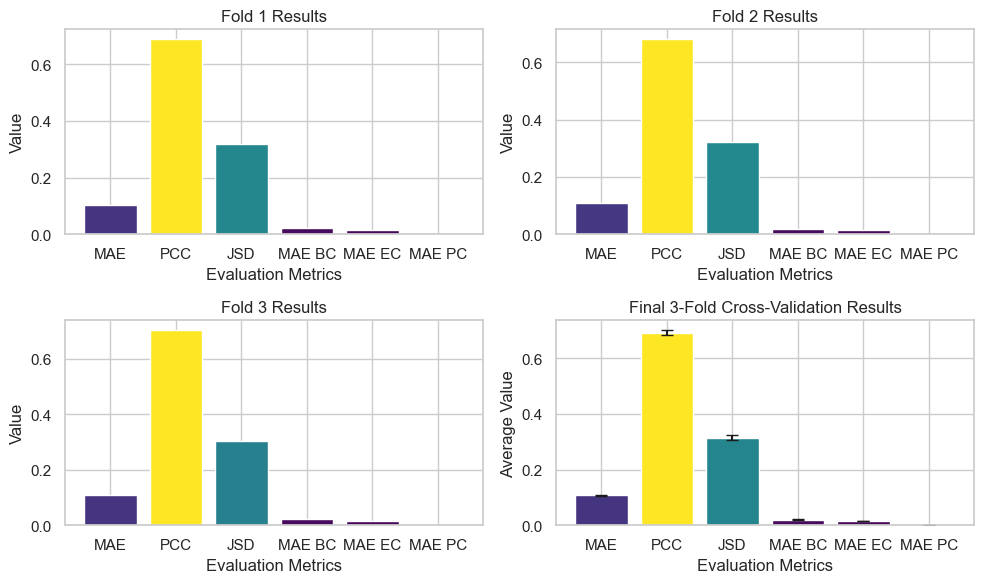

In [3]:

metrics = ['MAE', 'PCC', 'JSD', 'MAE BC', 'MAE EC', 'MAE PC']
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(metrics, foldOne, label='Fold 1', color=my_cmap(rescale(foldOne)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 1 Results')
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.bar(metrics, foldTwo, label='Fold 2', color=my_cmap(rescale(foldTwo)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 2 Results')
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.bar(metrics, foldThree, label='Fold 3', color=my_cmap(rescale(foldThree)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 3 Results')
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.bar(metrics, avg_values, yerr=std_values,color=my_cmap(rescale(avg_values)), capsize=4)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Average Value')
plt.title('Final 3-Fold Cross-Validation Results')
plt.tight_layout()
plt.show()

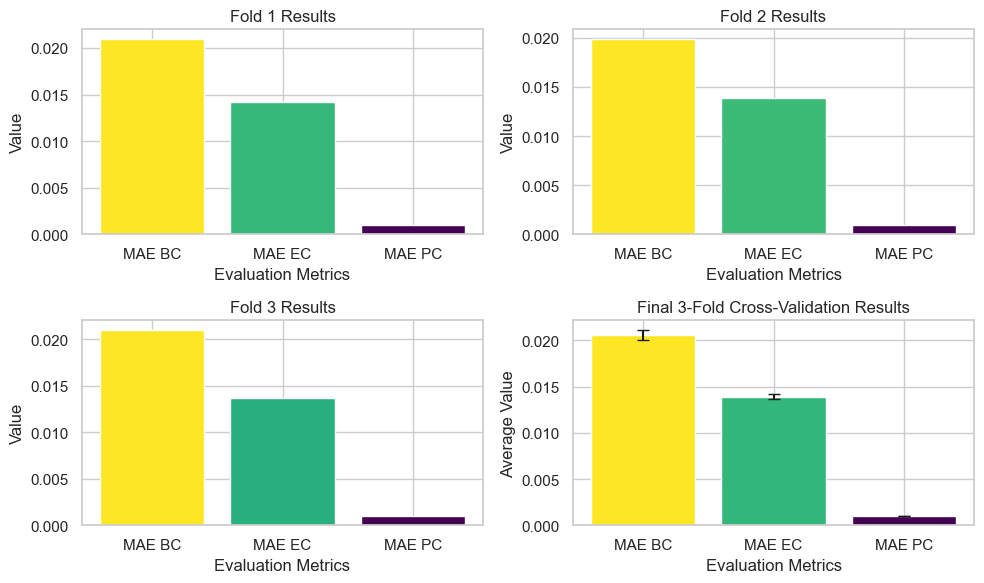

In [5]:
metrics = ['MAE BC', 'MAE EC', 'MAE PC']
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

foldOne = [all_avg_mae_bc[0], all_avg_mae_ec[0], all_avg_mae_pc[0]]
foldTwo = [ all_avg_mae_bc[1], all_avg_mae_ec[1], all_avg_mae_pc[1]]
foldThree = [ all_avg_mae_bc[2], all_avg_mae_ec[2], all_avg_mae_pc[2]]

avg_values = [ avg_mae_bc, avg_mae_ec, avg_mae_pc]
std_values = [std_mae_bc, std_mae_ec, std_mae_pc]

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(metrics, foldOne, label='Fold 1', color=my_cmap(rescale(foldOne)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 1 Results')
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.bar(metrics, foldTwo, label='Fold 2', color=my_cmap(rescale(foldTwo)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 2 Results')
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.bar(metrics, foldThree, label='Fold 3', color=my_cmap(rescale(foldThree)))
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Fold 3 Results')
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.bar(metrics, avg_values, yerr=std_values,color=my_cmap(rescale(avg_values)), capsize=4)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Average Value')
plt.title('Final 3-Fold Cross-Validation Results')
plt.tight_layout()
plt.show()

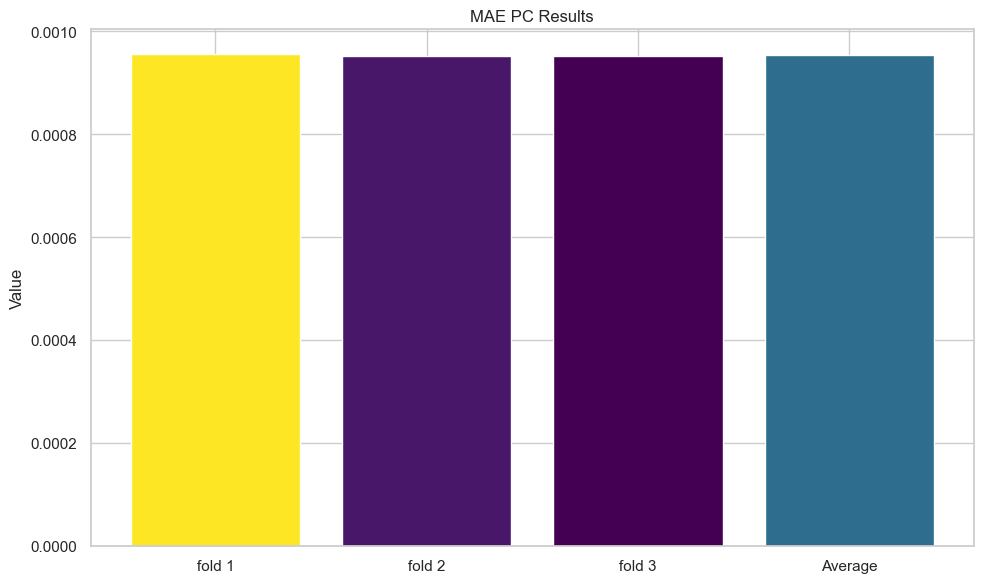

In [12]:
metrics = ['fold 1', 'fold 2', 'fold 3', 'Average']
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

foldOne = [ all_avg_mae_pc[0]]
foldTwo = [all_avg_mae_pc[1]]
foldThree = [  all_avg_mae_pc[2]]
mae_pc_final = foldOne + foldTwo + foldThree 
avg_values = [avg_mae_pc]
std_values = [std_mae_pc]
mae_pc_final.append(avg_mae_pc)

plt.figure(figsize=(10, 6))
plt.bar(metrics, mae_pc_final, label='MAE PC', color=my_cmap(rescale(mae_pc_final)))
plt.title('MAE PC Results')
plt.ylabel('Value')
plt.tight_layout()

plt.show()